In [1]:
#conda install -c districtdatalabs yellowbrick
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport
import sklearn
# sklearn.set_config(transform_output="pandas")
# import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

labeller  =  preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()

In [2]:
order_items = pd.read_csv('./dataset/olist_order_items_dataset.csv')
customers = pd.read_csv('./dataset/olist_customers_dataset.csv')
sellers = pd.read_csv('./dataset/olist_sellers_dataset.csv')
products = pd.read_csv('./dataset/olist_products_dataset.csv')
orders = pd.read_csv('./dataset/olist_orders_dataset.csv')
reviews = pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
geos = pd.read_csv('./dataset/olist_geolocation_dataset.csv')



In [3]:
# orders.info()
# order_items.info()

In [4]:

orders[['order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date']] = orders[['order_purchase_timestamp',
                                                    'order_approved_at',
                                                    'order_delivered_carrier_date',
                                                    'order_delivered_customer_date',
                                                    'order_estimated_delivery_date']].apply(pd.to_datetime) 
reviews[['review_creation_date',
        'review_answer_timestamp']] = reviews[['review_creation_date',
                                                    'review_answer_timestamp']].apply(pd.to_datetime) 
order_items[['shipping_limit_date']] = order_items[['shipping_limit_date']].apply(pd.to_datetime)
# order_items.info(),orders.info()
# order_items.head()
# customers.head(),order_items.head(),orders.head(),customers[customers['customer_id'] == "9ef432eb6251297304e76186b10a928d"], customers[customers['customer_unique_id'] == "9ef432eb6251297304e76186b10a928d"]
# ProfileReport(order_items,title="order of items").to_widgets()

# orders.info()
merged = orders.merge(order_items, how='inner')

merged = merged.merge(customers)
# merged.info()
merged = merged.merge(sellers)
merged = merged.merge(products)
merged = merged.merge(reviews)


merged['product_photos_qty']=merged['product_photos_qty'].fillna(0)
# merged[merged['product_photos_qty'].isna()][['customer_id','product_photos_qty']]

# merged[['seller_city','seller_state','customer_city','customer_state']] = merged[['seller_city','seller_state','customer_city','customer_state']].astype('category') 
# merged[['seller_city','seller_state','customer_city','customer_state']].info()
# print(merged[['seller_city','seller_state','customer_city','customer_state','review_score']].head())
# print(merged['customer_city'].value_counts())
# merged['seller_city'] = labeller.fit_transform(merged['seller_city'].astype('str'))
# merged['seller_state'] = labeller.fit_transform(merged['seller_state'].astype('str'))
# merged['customer_city'] = labeller.fit_transform(merged['customer_city'].astype('str'))
# merged['customer_state'] = labeller.fit_transform(merged['customer_state'].astype('str'))
merged['review_score'] = labeller.fit_transform(merged['review_score'].astype('str'))

# print(merged[['seller_city','seller_state','customer_city','customer_state','review_score']].head())
# merged[['seller_city','seller_state','customer_city','customer_state','review_score']].info()


merged['time_to_get'] = merged.order_delivered_customer_date - merged['order_purchase_timestamp']
merged['time_to_get'] = merged['time_to_get'].dt.seconds/(60*60)
merged['time_to_get'] = merged['time_to_get']

merged.sort_values(by='order_purchase_timestamp',inplace=True)
# merged['time_to_get'] = merged['time_to_get'].replace(np.nan, 0)
# merged.time_to_get.isna().sum()
merged.dropna(subset=['price'],inplace=True)
# print(merged.info())



In [5]:
# one hot encoding on the seller city and customer city
tohe = ohe.fit_transform(merged[['seller_city']])
one_hot = pd.get_dummies(merged['seller_city'], prefix='seller_from')
merged = pd.concat([merged, one_hot], axis=1)


tohe = ohe.fit_transform(merged[['customer_city']])
one_hot2 = pd.get_dummies(merged['customer_city'], prefix='customer_from')
merged = pd.concat([merged, one_hot2], axis=1)





In [6]:
all_ohc = list(one_hot.columns)+list(one_hot2.columns)

In [7]:
merged.dropna(subset=['order_approved_at', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                      'order_delivered_carrier_date', 'order_delivered_customer_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght','time_to_get'],inplace=True)
merged.fillna(value={'review_comment_title':'no comment', 'review_comment_message':'no_comment'},inplace=True)


# print(merged.info())
# print(len(merged.index))

<Axes: >

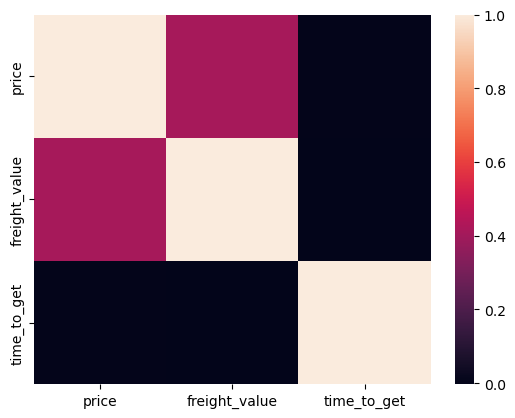

In [8]:
#without further preprocessing
merged['seller_city'] = labeller.fit_transform(merged['seller_city'].astype('str'))
merged['seller_state'] = labeller.fit_transform(merged['seller_state'].astype('str'))
merged['customer_city'] = labeller.fit_transform(merged['customer_city'].astype('str'))
merged['customer_state'] = labeller.fit_transform(merged['customer_state'].astype('str'))

X = merged[['price',
            'freight_value',
            # 'seller_city',
            # 'seller_state'
            # ,'customer_city',
            # 'customer_state',
            'time_to_get']]
# merged['review_score_transformed'] = merged['review_score']-1

# first we are goin to map seller_city and seller_satate and its customer conterpart to  unique integer,later we are also going to test one hot encoding
y = merged['review_score']


# sns.heatmap(merged[['price','freight_value','time_to_get','review_score']].corr())
sns.heatmap(X.corr())
# sns.heatmap(merged[['price','freight_value','time_to_get','review_score']].var)

In [9]:
y.value_counts(normalize=True)


4    0.575846
3    0.192499
0    0.113744
2    0.084333
1    0.033578
Name: review_score, dtype: float64

In [10]:
from time import time
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#train the simple decision tree model
time_check = {"dtc":0,"xgb":0,"rf":0}
s = time()
dtc_model = tree.DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)
time_check['dtc'] = time() - s
dtc_pred = dtc_model.predict(X_test)
dtc_report = classification_report(y_test, dtc_pred)
print("Decision Tree Classification Report:")
print(dtc_report)
print("for(s):", time_check['dtc'])



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.34      0.33      3668
           1       0.21      0.21      0.21      1120
           2       0.22      0.23      0.22      2766
           3       0.29      0.30      0.29      6317
           4       0.64      0.62      0.63     18668

    accuracy                           0.48     32539
   macro avg       0.34      0.34      0.34     32539
weighted avg       0.49      0.48      0.48     32539

for(s): 0.44754457473754883


In [11]:
s = time()
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
time_check['xgb'] = time() - s
xgb_pred = xgb_model.predict(X_test)
xgb_report = classification_report(y_test, xgb_pred)
print("XGBoost Classification Report:")
print(xgb_report)
print("for(s):", time_check['xgb'])

# Train the Random Forest model


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.03      0.06      3668
           1       0.64      0.01      0.02      1120
           2       0.62      0.01      0.01      2766
           3       0.53      0.01      0.02      6317
           4       0.58      1.00      0.73     18668

    accuracy                           0.58     32539
   macro avg       0.59      0.21      0.17     32539
weighted avg       0.58      0.58      0.43     32539

for(s): 11.050711393356323


In [12]:
s = time()
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
time_check['rf'] = time() - s
rf_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_pred)
print("Random Forest Classification Report:")
print(rf_report)
print("for(s):", time_check["rf"])

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.28      0.37      3668
           1       0.50      0.19      0.27      1120
           2       0.44      0.17      0.24      2766
           3       0.40      0.20      0.27      6317
           4       0.63      0.87      0.73     18668

    accuracy                           0.59     32539
   macro avg       0.50      0.34      0.38     32539
weighted avg       0.55      0.59      0.54     32539

for(s): 13.191413640975952


In [13]:
from sklearn.neighbors import KNeighborsClassifier
s = time()
knn_model = KNeighborsClassifier(5,weights='uniform')
knn_model.fit(X_train, y_train)
time_check['knn'] = time() - s

print("k-NN Classification Report:")
# print(knn_report)
print("for(s):", time_check["knn"])


k-NN Classification Report:
for(s): 0.05617403984069824


In [14]:
knn_pred = knn_model.predict(X_test)
knn_report = classification_report(y_test, knn_pred,output_dict=True)
pd.DataFrame(knn_report).transpose()

,precision,recall,f1-score,support
0,0.239878,0.214831,0.226665,3668.000000
1,0.156977,0.072321,0.099022,1120.000000
2,0.168098,0.099060,0.124659,2766.000000
3,0.247356,0.199937,0.221133,6317.000000
4,0.600809,0.708110,0.650061,18668.000000
accuracy,0.480193,0.480193,0.480193,0.480193
macro avg,0.282624,0.258852,0.264308,32539.000000
weighted avg,0.439445,0.480193,0.455434,32539.000000


Text(0.5, 0.98, 'K-NN(5,uniform)')

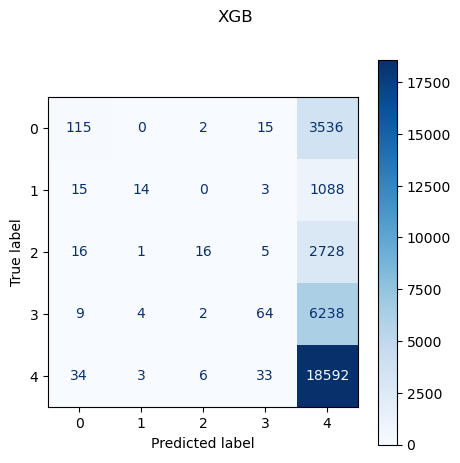

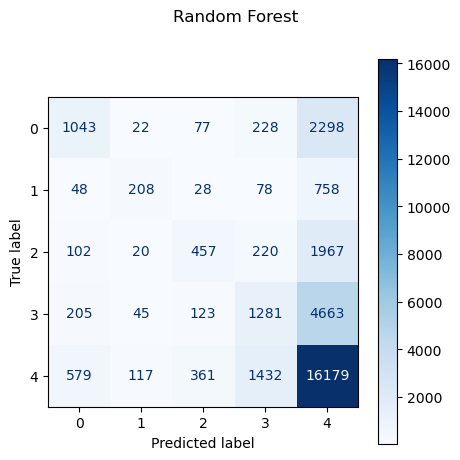

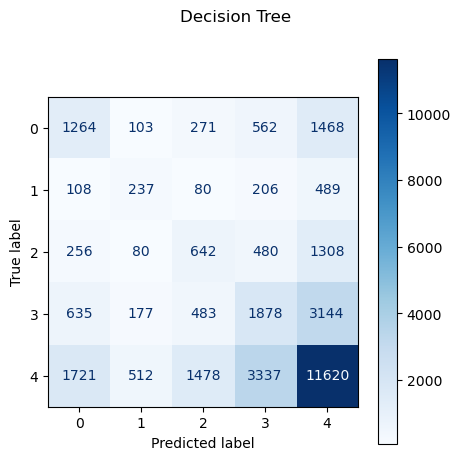

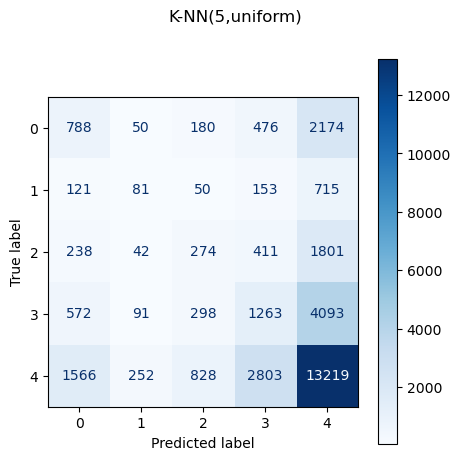

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# fg, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 8))
disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              xgb_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig = disp.figure_
fig.set_figwidth(5)
fig.set_figheight(5) 
fig.suptitle('XGB')


disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              rf_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig2 = disp.figure_
fig2.set_figwidth(5)
fig2.set_figheight(5) 
fig2.suptitle('Random Forest')


disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              dtc_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig2 = disp.figure_
fig2.set_figwidth(5)
fig2.set_figheight(5) 
fig2.suptitle('Decision Tree')

disp = ConfusionMatrixDisplay.from_predictions(
                                              y_test, 
                                              knn_pred, 
                                            #   display_labels=labels, 
                                              cmap=plt.cm.Blues
                                              ) 
fig2 = disp.figure_
fig2.set_figwidth(5)
fig2.set_figheight(5) 
fig2.suptitle('K-NN(5,uniform)')

/home/puztiq-03/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/puztiq-03/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/puztiq-03/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


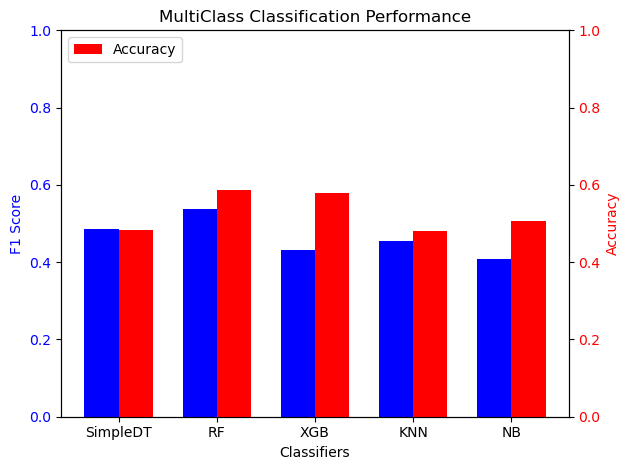

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

def plot_multiclass_classification_performance(X_train, y_train, X_test, y_test):
    # Initialize classifiers
    classifiers = [
        tree.DecisionTreeClassifier(),
        RandomForestClassifier(),
        xgb.XGBClassifier(),
        KNeighborsClassifier(),
        MultinomialNB()
    ]
    classifier_names = [
        'SimpleDT', 
        'RF',
        'XGB',
        'KNN',
        'NB']
    
    # Initialize lists to store F1 scores and accuracies
    f1_scores = []
    accuracies = []
    
    # Train and evaluate classifiers
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1_scores.append(report['weighted avg']['f1-score'])
        accuracies.append(report['accuracy'])
    
     # Create a bar plot
    x = np.arange(len(classifier_names))
    width = 0.35
    fig, ax1 = plt.subplots()

    ax1.bar(x - width/2, f1_scores, width, label='F1 Score', color='b')
    ax1.set_xlabel('Classifiers')
    ax1.set_ylabel('F1 Score', color='b')
    ax1.set_ylim(0,1.)
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.bar(x + width/2, accuracies, width, label='Accuracy', color='r')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(0,1.)
    
    # plt.set_xticks(x, classifier_names, rotation=45,ha='right')
    plt.xticks(x, classifier_names)
    # plt.ylim(0,1.)
    plt.title(f"MultiClass Classification Performance")
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Load the Iris dataset for demonstration purposes
# iris = load_iris()
# X = iris.data
# y = iris.target

# Call the function to plot the performance
# "Hello {name}. Your age is {age} ".format(name=user,age=age)
plot_multiclass_classification_performance(X_train, y_train, X_test, y_test)


In [17]:
from imblearn.over_sampling import SMOTE

# ADASYN
X_SMOTE,Y_SMOTE =  SMOTE().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_SMOTE,Y_SMOTE, test_size=0.3, random_state=42)


In [18]:
# s = time()
# knn_model = KNeighborsClassifier(5,weights='uniform')
# knn_model.fit(X_train, y_train)
# time_check['knn'] = time() - s

# print("k-NN Classification Report:")
# # print(knn_report)
# print("for(s):", time_check["knn"])

# knn_pred = knn_model.predict(X_test)
# knn_report = classification_report(y_test, knn_pred,output_dict=True)
# pd.DataFrame(knn_report).transpose()

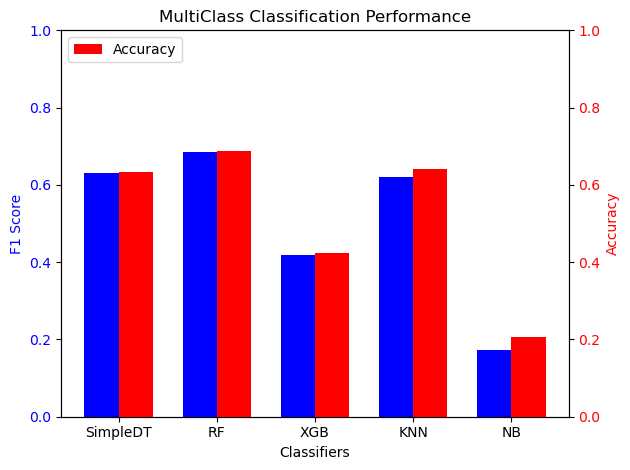

In [19]:
plot_multiclass_classification_performance(X_train, y_train, X_test, y_test)

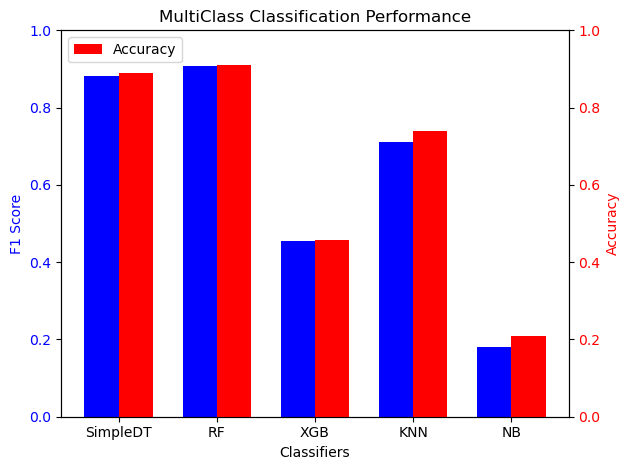

In [23]:
from imblearn.over_sampling import RandomOverSampler
X_RDOS,Y_RDOS =  RandomOverSampler().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_RDOS,Y_RDOS, test_size=0.3, random_state=42)
plot_multiclass_classification_performance(X_train, y_train, X_test, y_test)

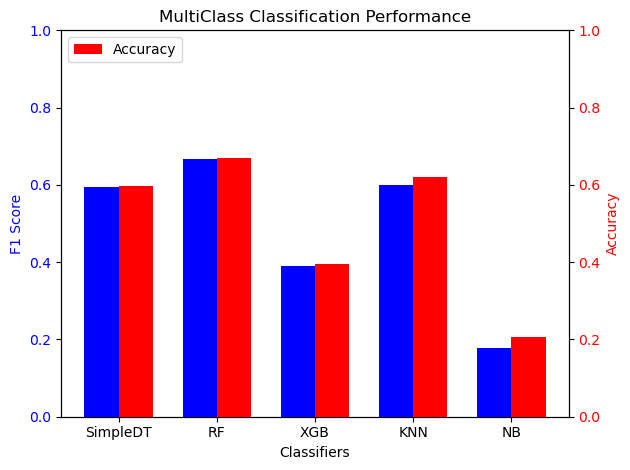

In [24]:
from imblearn.over_sampling import ADASYN
X_ADASYN,Y_ADSYN =  ADASYN().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_ADASYN,Y_ADSYN, test_size=0.3, random_state=42)
plot_multiclass_classification_performance(X_train, y_train, X_test, y_test)

In [ ]:
from imblearn.under_sampling import ClusterCentroids
X_CC ,Y_CC = ClusterCentroids(random_state=0).fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_ADASYN,Y_ADSYN, test_size=0.3, random_state=42)
plot_multiclass_classification_performance(X_train, y_train, X_test, y_test)